**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [49]:
import keras
import numpy as np
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import skvideo
skvideo.setFFmpegPath("/anaconda3/pkgs/ffmpeg-4.1-ha0c5888_0/bin/")
import skvideo.io
import cv2
import json
import matplotlib.pyplot as plt

from keras.models import Sequential, model_from_json
from keras.layers.core import Dense
from keras.engine.input_layer import Input
from keras.models import Model
from keras.optimizers import sgd, RMSprop, Adam
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D, Reshape, BatchNormalization, Flatten, Dropout

# MiniProject #3: Deep Reinforcement Learning

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

\begin{equation*}
R(\pi)=\sum_{t\leq T}E_{p^{\pi}}[\gamma^t r(s_{t},a_{t})] \> ,
\end{equation*}

where: 
\begin{equation*}p^{\pi}(a_{0},a_{1},s_{1},...,a_{T},s_{T})=p(a_{0})\prod_{t=1}^{T}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) \> .
\end{equation*}

We note the $Q$-function:

\begin{equation*}Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \> .
\end{equation*}

Thus, the optimal Q function is:
\begin{equation*}
Q^*(s,a)=\max_{\pi}Q^\pi(s,a) \> .
\end{equation*}

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [3]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?

        :return: state, reward, game_over
        """
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [24]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self, e):
        self.epsilon = e

    def act(self, s, train=True, eps=False):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            if eps:
                if np.random.rand() <= 0.05:
                    a = np.random.randint(0, self.n_action, size=1)[0]
                else:
                    a = self.learned_act(s) 
            else :
                a = self.learned_act(s)

        return a

    def learned_act(self, s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

In the function *act*, the agent is using an $\epsilon$-greedy policy. With probability $\epsilon$, it chooses a random action (1st line of *if*), and with probability $1-\epsilon$ it chooses the optimal action (i.e. greedy policy) according to the policy it has learned (through function ```learned_act```).

---

Setting $\epsilon$ non-negative is essential because it ensures the agent will not stop exploring and thus visiting each (state, action) tuple an infinite number of time. This condition is necessary for the stochastic approximation theorem to apply and show the convergence of the $Q$-function to the optimal one $Q^*$.

***
### The Game

The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
```

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [5]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size + 4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the cat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale = 16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self, e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self, t):
        b = np.zeros((self.grid_size, self.grid_size,3), dtype=np.uint8) + 128
        b[self.board>0, 0] = 256
        b[self.board < 0, 2] = 256
        b[self.x, self.y, :] = 256
        b[-2:,:,:] = 0
        b[:,-2:,:] = 0
        b[:2,:,:] = 0
        b[:,:2,:] = 0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:] = b


    def act(self, action, train=False):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:,:] = -1
        self.position[-2:,:] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size - 3:
                self.x = self.x - 1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [40]:
# parameters
size = 13
T = 200
temperature = 0.3
epochs_train = 500 # set small when debugging
epochs_test = 10 # set small when debugging

# display videos
def display_videos(name):
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

__Question 2__ Explain the use of the arrays ```position``` and ```board```.

The array ```position``` is used to defined where the agent is and what he can see (i.e. if squares are empty ($0$) or impossible to go ($-1$)) from his position (up to $2$ squares in each directions). 

---
The array ```board``` is used to handle the reward at each square of the environment board. Malus and bonus are first defined in the ```reset```function, and then affected to each square of the board : ```self.board = bonus + malus```. When the agent reach square of coordinates $(self.x, self.y)$, it receives the reward affected to this square (if any) : ```reward = self.board[self.x, self.y]``` , and then the reward of the square is set to 0 : ```self.board[self.x, self.y] = 0```.

## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

In [70]:
from random import randint

class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()
        pass

    def learned_act(self, s):
        return randint(0, 3)

***
***
__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

In [25]:
def test(agent, env, epochs, prefix='', eps=False):
    # Number of won games
    score = 0
    
    list_wl = np.zeros((epochs, 2))
    list_score = np.zeros(epochs)
    
    print('Testing {} for temperature {}'.format(prefix, env.temperature))
    
    for e in range(epochs):
      
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will end
        game_over = False
        t = 0
        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state, train=False, eps=eps)
            
            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action, train=False)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Save frame
            env.get_frame(t)
            t=t+1

        # Update stats
        score = score + win-lose
        list_score[e] = score
        list_wl[e, 0] = win
        list_wl[e, 1] = lose
        
        # Save game
        #print(prefix+str(e))
        
        env.draw('{}_{}_test_{}'.format(prefix,env.temperature,e))

        
        #print("Win/lose count {}/{}. Average score ({})"
        #      .format(win, lose, score/(1+e)))
    print('Final score: '+str(score/epochs))
   
    return list_wl, list_score

In [74]:
# Initialize the game
env = Environment(grid_size=size, max_time=T, temperature=temperature)

# Initialize the agent!
agent = RandomAgent()

list_wl_rd, list_score_rd = test(agent, env,epochs_test, prefix='random')
#HTML(display_videos('random3.mp4'))

Testing random for temperature 0.3
Final score: -1.05


***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}


Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}
Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}






---


1) We have :
\begin{align}
Q^\pi(s,a) &= E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \\
           &= \sum_{s'}r(s,a)p(s'|s,a) + \sum_{s',a'}p(s',a'|a,s)E_{p^{\pi}}[\sum_{1\leq t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a, s_{1}=s', a_{1}=a']
\end{align}

From Markov property, we have :
\begin{align}
E_{p^{\pi}}[\sum_{1 \leq t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a, s_{1}=s', a_{1}=a'] &= \gamma E_{p^{\pi}}[\sum_{1 \leq t\leq T}\gamma^{t-1}r(s_{t},a_{t})|s_{1}=s', a_{1}=a'] \\
&= \gamma E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s', a_{0}=a'] 
\end{align}

Hence : 
\begin{align}
Q^\pi(s,a) &= \sum_{s'}r(s,a)p(s'|s,a) + \gamma \sum_{s',a'}p(s',a'|a,s) E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s', a_{0}=a'] \\
& = \sum_{s'}r(s,a)p(s'|s,a) + \gamma E_{(s',a')\sim p(.|s,a)}[Q^{\pi}(s',a')] \\
&=\sum_{s'}r(s,a)p(s'|s,a) + E_{(s',a')\sim p(.|s,a)}[\gamma Q^{\pi}(s',a')] \\
&=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{align}


---

2) From the definition,
\begin{align}
Q^*(s,a) &=\max_{\pi}Q^\pi(s,a) \\
&=\max_{\pi}E_{(s',a')\sim p^{\pi}(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')] \\
&= \sum_{s'}r(s,a)p(s'|s,a) + \gamma\max_{\pi}E_{(s',a')\sim p^{\pi}(.|s,a)}[Q^{\pi}(s',a')] \\
&= \sum_{s'}r(s,a)p(s'|s,a) + \gamma\max_{\pi}\sum_{s'}\sum_{a'}[Q^{\pi}(s',a')]\pi(a'|s')p(s'|s,a)
\end{align}

Then, one can use the optimality principle : to be optimal, a policy must be optimal at each state, so given a state choose the best action and then be optimal for the resulting states. As a result, we can write : 
\begin{align}
\max_{\pi}\sum_{s'}\sum_{a'}Q^{\pi}(s',a')\pi(a'|s')p(s'|s,a) &= \max_{a',\pi'}\sum_{s'}\sum_{a'}[Q^{\pi'}(s',a')]\pi(a'|s')p(s'|s,a)
\end{align}
with $\pi'$ the policy followed after choosing action $a'$ at a given state.
By definition of the optimal $Q-function$:
\begin{align}
\max_{a',\pi'}\sum_{s'}\sum_{a'}[Q^{\pi'}(s',a')]\pi(a'|s')p(s'|s,a) &= \sum_{s'}p(s'|s,a)\max_{a'}\sum_{a'}\max_{pi'}[Q^{\pi'}(s',a')]\pi(a'|s') \\
&= \sum_{s'}p(s'|s,a)\sum_{a'}\max_{a'}[Q^{*}(s',a')]\pi^{*}(a'|s') \\
&= E_{s'\sim \pi^*(.|s,a)}[\max_{a'}Q^{*}(s',a')]
\end{align}

Eventually:
\begin{align}
Q^*(s,a) &= \sum_{s'}r(s,a)p(s'|s,a) + \gamma E_{s'\sim \pi^*(.|s,a)}[\max_{a'}Q^{*}(s',a')] \\
&= E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')]
\end{align}

---

3) We use the Temporal-Difference method to learn the $Q$-function, based on the stochastic approximation algorithm for a fixed point (here the optimal Q-Function is the fixed point of the optimal Bellman operator $B$ defined as $BQ(s,a) = E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q(s',a')]$). At each step of the optimisation step, we try to minimize the distance between each part of the recursive equation defining $Q^*$, which is \begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}. Hence we minimize the following loss function :
\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}

***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [8]:
class Memory(object):
    def __init__(self, max_memory=100, nb_s=2):
        self.max_memory = max_memory
        self.state = np.zeros((max_memory,5,5,nb_s))
        self.n_state = np.zeros((max_memory,5,5,nb_s))
        self.action = np.zeros(max_memory)
        self.reward = np.zeros(max_memory)
        self.game_over = np.zeros(max_memory)
        self.cursor = 0
        self.full = False

    def remember(self, m):
        self.state[self.cursor] = m[0]
        self.n_state[self.cursor] = m[1]
        self.action[self.cursor] = m[2]
        self.reward[self.cursor] = m[3]
        self.game_over[self.cursor] = m[4]
        
        self.cursor += 1
        if self.cursor > self.max_memory-1:
            self.full = True
            self.cursor = 0

    def random_access(self):
        if self.full: 
            i = randint(0, self.max_memory-1)
        else :
            i = randint(0, self.cursor)
        return [self.state[i,:,:,:],  self.n_state[i,:,:,:], 
                 self.action[i], self.reward[i], self.game_over[i]]

***
The pipeline we will use for training is given below:

In [9]:
def train(agent,env,epoch,prefix=''):
    # Number of won games
    score = 0
    loss = 0
    
    list_wl = np.zeros((epoch, 2))
    list_score = np.zeros(epoch)
    list_loss = []
    
    print('Training {} for temperature {}'.format(prefix, env.temperature))
    
    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose - reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)
            list_loss.append(loss)
     
        # Refresh target model
        #if e % 10 == 0:
        #  agent.set_target_model()
        
        
        # Save as a mp4
        if e % 10 == 0:
            env.draw('{}_{}_{}'.format(prefix,env.temperature,e))

        # Update stats
        score += win-lose
        list_score[e] = score
        list_wl[e, 0] = win
        list_wl[e, 1] = lose
        

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights='{}_{}_model.h5'.format(prefix, env.temperature),name_model='{}_{}_model.json'.format(prefix, env.temperature))
    
    #files.download('{}_{}_model.h5'.format(prefix, env.temperature))
    #files.download('{}_{}_model.json'.format(prefix, env.temperature))
    
    return list_wl, list_score, list_loss 

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

In [26]:
class DQN(Agent):
    def __init__(self, grid_size,  epsilon = 0.1, memory_size=100, batch_size=16, n_state=2):
        super(DQN, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size, n_state)
        
        # Batch size when learning
        self.batch_size = batch_size
        
        # Training_loss
        self.train_loss = []

    def learned_act(self, s):
        return np.argmax(self.model.predict(s[None,:,:,:]))

    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        # Two steps: first memorize the states, second learn from the pool

        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        
        input_states = np.zeros((self.batch_size, 5, 5, self.n_state))
        target_q = np.zeros((self.batch_size, 4))
        
        for i in range(self.batch_size):
            [s, n_s, a, r, game_over] = self.memory.random_access()
            a = int(a)
            input_states[i] = s
            target_q[i,:] = self.model.predict(s[None,:,:,:])
            if game_over_:
                target_q[i,a] = r
            else:
                target_q[i,a] = r + self.discount*np.max(self.model.predict(n_s[None,:,:,:]))

        # HINT: Clip the target to avoid exploiding gradients.. -- clipping is a bit tighter
        target_q = np.clip(target_q, -1, 1)

        l = self.model.train_on_batch(input_states, target_q)
        self.train_loss.append(l)
        
        return l

    def save(self, name_weights='model.h5', name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self, name_weights='model.h5', name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("sgd", "mse")
        self.model = model
        
    #def set_target_model(self):
    #      self.target_model.set_weights(self.model.get_weights()) 
    
            
class DQN_FC(DQN):
    def __init__(self, *args, lr=0.1, nb_layer=4, nb_neur=32, **kwargs):
        super(DQN_FC, self).__init__(*args, **kwargs)
        
        # NN Train Model
        screen_input = Input(shape=(5,5,self.n_state))
        s1 = Flatten()(screen_input)
        for i in range(nb_layer):
            s1 = Dense(nb_neur, activation='relu')(s1)
        pred = Dense(4, activation='linear')(s1)
        
        model = Model(inputs=screen_input, outputs=pred)
        
        model.summary()
        model.compile(Adam(lr=lr, decay=1e-4), "mse")
        self.model = model
        
        # NN Target Model
        #screen_input = Input(shape=(5,5,self.n_state))
        #s1 = Flatten()(screen_input)
        #for i in range(nb_layer):
        #  s1 = Dense(nb_neur, activation='relu')(s1)
        #pred = Dense(4,activation='linear')(s1)
        
        #model = Model(inputs=screen_input, outputs=pred)
        
        #model.summary()
        #model.compile(Adam(lr=lr, decay=1e-4), "mse")
        #self.target_model = model
        #self.target_model.set_weights(self.model.get_weights())

In [95]:
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_FC(size, lr=0.01, epsilon=0.1, memory_size=2000, batch_size=32, nb_layer=3, nb_neur=32)
list_wl, list_score, list_loss = train(agent, env, epochs_train, prefix='fc_train')
#HTML(display_videos('fc_train10.mp4'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 5, 5, 2)           0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 50)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 32)                1632      
_________________________________________________________________
dense_39 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_40 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_41 (Dense)             (None, 4)                 132       
Total params: 3,876
Trainable params: 3,876
Non-trainable params: 0
_________________________________________________________________
Training

Epoch 119/500 | Loss 0.1888 | Win/lose count 4.0/5.0 (-1.0)
Epoch 120/500 | Loss 0.2008 | Win/lose count 7.5/4.0 (3.5)
Epoch 121/500 | Loss 0.1973 | Win/lose count 5.0/3.0 (2.0)
Epoch 122/500 | Loss 0.2020 | Win/lose count 6.0/3.0 (3.0)
Epoch 123/500 | Loss 0.1903 | Win/lose count 8.0/6.0 (2.0)
Epoch 124/500 | Loss 0.1848 | Win/lose count 6.0/5.0 (1.0)
Epoch 125/500 | Loss 0.1954 | Win/lose count 2.5/5.0 (-2.5)
Epoch 126/500 | Loss 0.1843 | Win/lose count 4.0/3.0 (1.0)
Epoch 127/500 | Loss 0.1750 | Win/lose count 9.0/3.0 (6.0)
Epoch 128/500 | Loss 0.1708 | Win/lose count 4.0/4.0 (0.0)
Epoch 129/500 | Loss 0.1705 | Win/lose count 5.0/7.0 (-2.0)
Epoch 130/500 | Loss 0.1828 | Win/lose count 6.5/3.0 (3.5)
Epoch 131/500 | Loss 0.1697 | Win/lose count 3.0/4.0 (-1.0)
Epoch 132/500 | Loss 0.1859 | Win/lose count 4.5/6.0 (-1.5)
Epoch 133/500 | Loss 0.1730 | Win/lose count 4.5/1.0 (3.5)
Epoch 134/500 | Loss 0.1840 | Win/lose count 7.0/2.0 (5.0)
Epoch 135/500 | Loss 0.1620 | Win/lose count 11.5/7

Epoch 258/500 | Loss 0.1709 | Win/lose count 4.0/3.0 (1.0)
Epoch 259/500 | Loss 0.1743 | Win/lose count 3.0/3.0 (0.0)
Epoch 260/500 | Loss 0.1653 | Win/lose count 4.0/3.0 (1.0)
Epoch 261/500 | Loss 0.1590 | Win/lose count 5.5/3.0 (2.5)
Epoch 262/500 | Loss 0.1632 | Win/lose count 2.0/1.0 (1.0)
Epoch 263/500 | Loss 0.1713 | Win/lose count 8.5/4.0 (4.5)
Epoch 264/500 | Loss 0.1662 | Win/lose count 13.0/2.0 (11.0)
Epoch 265/500 | Loss 0.1680 | Win/lose count 11.0/6.0 (5.0)
Epoch 266/500 | Loss 0.1521 | Win/lose count 3.0/4.0 (-1.0)
Epoch 267/500 | Loss 0.1671 | Win/lose count 6.0/2.0 (4.0)
Epoch 268/500 | Loss 0.1682 | Win/lose count 6.5/1.0 (5.5)
Epoch 269/500 | Loss 0.1749 | Win/lose count 6.5/4.0 (2.5)
Epoch 270/500 | Loss 0.1721 | Win/lose count 2.0/1.0 (1.0)
Epoch 271/500 | Loss 0.1962 | Win/lose count 5.0/1.0 (4.0)
Epoch 272/500 | Loss 0.1737 | Win/lose count 9.5/4.0 (5.5)
Epoch 273/500 | Loss 0.1807 | Win/lose count 2.5/5.0 (-2.5)
Epoch 274/500 | Loss 0.1763 | Win/lose count 2.5/4.

Epoch 397/500 | Loss 0.1522 | Win/lose count 2.5/4.0 (-1.5)
Epoch 398/500 | Loss 0.1614 | Win/lose count 4.0/2.0 (2.0)
Epoch 399/500 | Loss 0.1630 | Win/lose count 5.0/4.0 (1.0)
Epoch 400/500 | Loss 0.1683 | Win/lose count 4.5/2.0 (2.5)
Epoch 401/500 | Loss 0.1608 | Win/lose count 5.0/3.0 (2.0)
Epoch 402/500 | Loss 0.1614 | Win/lose count 2.5/1.0 (1.5)
Epoch 403/500 | Loss 0.1605 | Win/lose count 8.0/3.0 (5.0)
Epoch 404/500 | Loss 0.1557 | Win/lose count 6.0/5.0 (1.0)
Epoch 405/500 | Loss 0.1545 | Win/lose count 8.5/6.0 (2.5)
Epoch 406/500 | Loss 0.1517 | Win/lose count 4.5/3.0 (1.5)
Epoch 407/500 | Loss 0.1466 | Win/lose count 6.0/5.0 (1.0)
Epoch 408/500 | Loss 0.1581 | Win/lose count 3.5/1.0 (2.5)
Epoch 409/500 | Loss 0.1593 | Win/lose count 3.0/3.0 (0.0)
Epoch 410/500 | Loss 0.1651 | Win/lose count 10.5/3.0 (7.5)
Epoch 411/500 | Loss 0.1594 | Win/lose count 3.5/1.0 (2.5)
Epoch 412/500 | Loss 0.1807 | Win/lose count 6.0/3.0 (3.0)
Epoch 413/500 | Loss 0.1761 | Win/lose count 7.0/4.0 (

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_conv(list_wl, list_score, list_loss, temp):
    if list_loss: 
        plt.figure(figsize=(15, 4))
        plt.subplot(1, 3, 1)
        plt.plot(list_score, label='score')
        plt.title('Cumulative Score for T = {}'.format(temp))
        plt.xlabel('Nb of epochs')
        plt.legend()

        cum_ind = np.cumsum(list_wl, axis=0)

        plt.subplot(1, 3, 2)
        plt.plot(cum_ind[:,0], label='win')
        plt.plot(cum_ind[:,1], label='loss')
        plt.title('Win vs. Loss cumulative count for T = {}'.format(temp))
        plt.xlabel('Nb of epochs')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(list_loss, label='loss')
        plt.title('DQN Training Loss for T = {}'.format(temp))
        plt.xlabel('Nb of steps')
        plt.legend()

        plt.tight_layout()
        plt.show()
      
    else:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(list_score, label='score')
        plt.title('Cumulative Score for T = {}'.format(temp))
        plt.xlabel('Nb of epochs')
        plt.legend()

        cum_ind = np.cumsum(list_wl, axis=0)

        plt.subplot(1, 2, 2)
        plt.plot(cum_ind[:,0], label='win')
        plt.plot(cum_ind[:,1], label='loss')
        plt.title('Win vs. Loss cumulative count for T = {}'.format(temp))
        plt.xlabel('Nb of epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()
    
    print('Average score per epoch is : {}'.format(np.mean(list_wl[:,0]-list_wl[:,1])))
    
    return
  


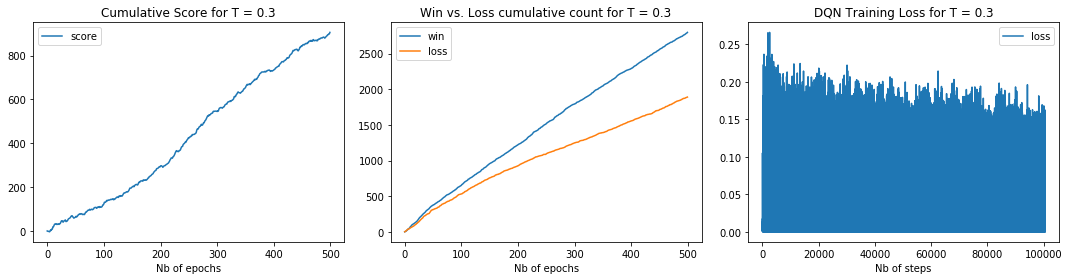

Average score per epoch is : 1.813


In [96]:
plot_conv(list_wl, list_score, list_loss, env.temperature)

Testing fc for temperature 0.3
Final score: 0.615


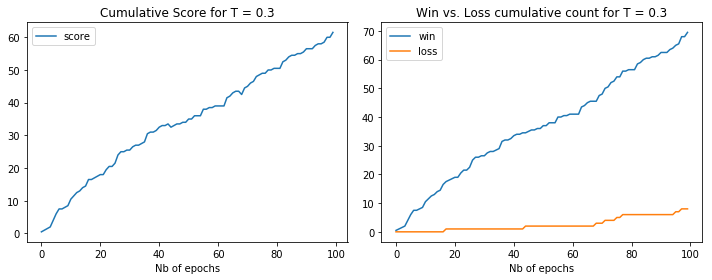

Average score per epoch is : 0.615


In [97]:
# Test FC
epochs_test = 100
list_wl_test, list_score_test = test(agent,env,epochs_test,prefix='fc')
plot_conv(list_wl_test, list_score_test, [], env.temperature)

![SegmentLocal](fc_test_03_test.gif "segment")

***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [27]:
class DQN_CNN(DQN):
    def __init__(self, *args, lr=0.01, dense=False, **kwargs):
        super(DQN_CNN, self).__init__(*args, **kwargs)
        
        # NN training model
        screen_input = Input(shape=(5, 5, self.n_state))
        s1 = Conv2D(16, (3, 3), strides=(2, 2), 
                    activation='relu')(screen_input)
        s1 = Conv2D(32, (2, 2), strides=(1, 1), 
                    activation='relu')(s1)
        s1 = Flatten()(s1)
        if dense:
            s1 = Dense(32, activation='relu')(s1)
        pred = Dense(4, activation='linear')(s1)
        model = Model(inputs=screen_input, outputs=pred)
        
        model.summary()
        model.compile(RMSprop(lr=lr, decay=1e-4), "mse")
        self.model = model
        
        # NN target model
        #screen_input = Input(shape=(5,5,self.n_state))
        #s1 = Conv2D(8, (2,2), strides=(3, 3), 
        #            activation='relu')(screen_input)
        #s1 = Conv2D(8, (2,2), strides=(2, 2), 
        #            activation='relu')(s1)
        #s1 = Flatten()(s1)
        #pred = Dense(4,activation='linear')(s1)
        #model = Model(inputs=screen_input, outputs=pred)
        
        #model.summary()
        #model.compile(Adam(lr=lr, decay=1e-5, clipvalue=1), "mse")
        #self.target_model = model
        #self.target_model.set_weights(self.model.get_weights())

In [84]:
epochs_train = 500
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=0.01, epsilon=0.1, memory_size=2000, batch_size=32, dense=True)
list_wl, list_score, list_loss = train(agent, env, epochs_train, prefix='cnn_train')
#HTML(display_videos('cnn_train10.mp4'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 5, 5, 2)           0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 2, 2, 16)          304       
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 1, 1, 32)          2080      
_________________________________________________________________
flatten_25 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_37 (Dense)             (None, 4)                 132       
Total params: 3,572
Trainable params: 3,572
Non-trainable params: 0
_________________________________________________________________
Training

Epoch 119/500 | Loss 0.2118 | Win/lose count 10.5/9.0 (1.5)
Epoch 120/500 | Loss 0.2301 | Win/lose count 9.5/2.0 (7.5)
Epoch 121/500 | Loss 0.2186 | Win/lose count 3.0/2.0 (1.0)
Epoch 122/500 | Loss 0.2275 | Win/lose count 9.5/6.0 (3.5)
Epoch 123/500 | Loss 0.2110 | Win/lose count 5.5/1.0 (4.5)
Epoch 124/500 | Loss 0.2071 | Win/lose count 9.5/2.0 (7.5)
Epoch 125/500 | Loss 0.2190 | Win/lose count 10.0/1.0 (9.0)
Epoch 126/500 | Loss 0.2190 | Win/lose count 5.5/3.0 (2.5)
Epoch 127/500 | Loss 0.2091 | Win/lose count 13.5/3.0 (10.5)
Epoch 128/500 | Loss 0.2135 | Win/lose count 10.5/7.0 (3.5)
Epoch 129/500 | Loss 0.1916 | Win/lose count 7.0/7.0 (0.0)
Epoch 130/500 | Loss 0.2112 | Win/lose count 15.5/8.0 (7.5)
Epoch 131/500 | Loss 0.2080 | Win/lose count 8.5/6.0 (2.5)
Epoch 132/500 | Loss 0.2107 | Win/lose count 5.5/2.0 (3.5)
Epoch 133/500 | Loss 0.2203 | Win/lose count 14.5/3.0 (11.5)
Epoch 134/500 | Loss 0.2389 | Win/lose count 8.5/7.0 (1.5)
Epoch 135/500 | Loss 0.2151 | Win/lose count 6.0

Epoch 257/500 | Loss 0.1946 | Win/lose count 6.0/4.0 (2.0)
Epoch 258/500 | Loss 0.1979 | Win/lose count 5.0/3.0 (2.0)
Epoch 259/500 | Loss 0.2090 | Win/lose count 13.5/1.0 (12.5)
Epoch 260/500 | Loss 0.1950 | Win/lose count 12.5/3.0 (9.5)
Epoch 261/500 | Loss 0.2125 | Win/lose count 9.5/3.0 (6.5)
Epoch 262/500 | Loss 0.1933 | Win/lose count 9.0/6.0 (3.0)
Epoch 263/500 | Loss 0.1937 | Win/lose count 14.0/3.0 (11.0)
Epoch 264/500 | Loss 0.2097 | Win/lose count 17.5/2.0 (15.5)
Epoch 265/500 | Loss 0.2168 | Win/lose count 11.0/2.0 (9.0)
Epoch 266/500 | Loss 0.2051 | Win/lose count 3.5/6.0 (-2.5)
Epoch 267/500 | Loss 0.2233 | Win/lose count 9.5/5.0 (4.5)
Epoch 268/500 | Loss 0.2082 | Win/lose count 15.0/6.0 (9.0)
Epoch 269/500 | Loss 0.1893 | Win/lose count 9.0/1.0 (8.0)
Epoch 270/500 | Loss 0.2251 | Win/lose count 9.5/1.0 (8.5)
Epoch 271/500 | Loss 0.2023 | Win/lose count 9.5/5.0 (4.5)
Epoch 272/500 | Loss 0.1885 | Win/lose count 7.0/6.0 (1.0)
Epoch 273/500 | Loss 0.2279 | Win/lose count 8

Epoch 395/500 | Loss 0.1859 | Win/lose count 14.0/3.0 (11.0)
Epoch 396/500 | Loss 0.1948 | Win/lose count 17.0/2.0 (15.0)
Epoch 397/500 | Loss 0.1907 | Win/lose count 18.5/2.0 (16.5)
Epoch 398/500 | Loss 0.1989 | Win/lose count 21.5/5.0 (16.5)
Epoch 399/500 | Loss 0.2119 | Win/lose count 12.5/3.0 (9.5)
Epoch 400/500 | Loss 0.2053 | Win/lose count 10.0/2.0 (8.0)
Epoch 401/500 | Loss 0.1911 | Win/lose count 8.0/6.0 (2.0)
Epoch 402/500 | Loss 0.2003 | Win/lose count 11.5/3.0 (8.5)
Epoch 403/500 | Loss 0.1995 | Win/lose count 8.0/1.0 (7.0)
Epoch 404/500 | Loss 0.1820 | Win/lose count 20.5/5.0 (15.5)
Epoch 405/500 | Loss 0.2079 | Win/lose count 10.5/2.0 (8.5)
Epoch 406/500 | Loss 0.1863 | Win/lose count 7.5/1.0 (6.5)
Epoch 407/500 | Loss 0.1883 | Win/lose count 17.5/1.0 (16.5)
Epoch 408/500 | Loss 0.1916 | Win/lose count 16.5/5.0 (11.5)
Epoch 409/500 | Loss 0.2122 | Win/lose count 10.5/3.0 (7.5)
Epoch 410/500 | Loss 0.1951 | Win/lose count 18.0/3.0 (15.0)
Epoch 411/500 | Loss 0.1876 | Win/l

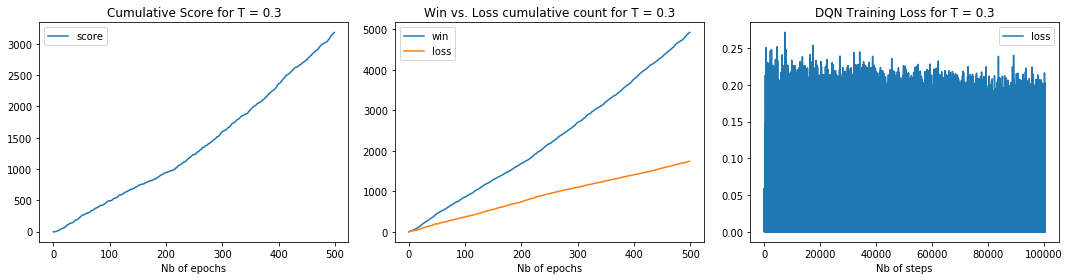

Average score per epoch is : 6.365


In [85]:
plot_conv(list_wl, list_score, list_loss, env.temperature)

Testing cnn for temperature 0.3
Final score: 3.11


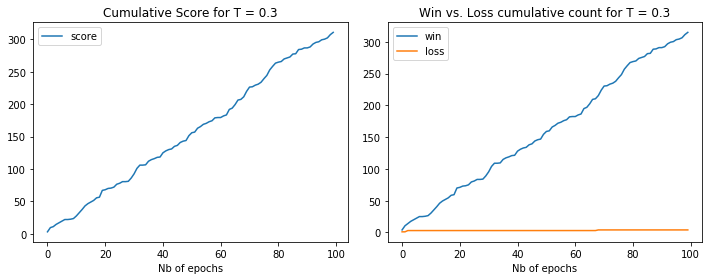

Average score per epoch is : 3.11


In [94]:
# Test CNN
epochs_test = 100
list_wl_test, list_score_test = test(agent,env,epochs_test,prefix='cnn')
plot_conv(list_wl_test, list_score_test, [], env.temperature)

![SegmentLocal](cnn_test_03_test.gif "segment")

***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature.

In [13]:
def plot_comp(list_score_1, list_score_2, list_wl_1, list_wl_2, temp, name):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(list_score_1, label=name[0])
    plt.plot(list_score_2, label=name[1])
    plt.title('Cumulative Score for T = {}'.format(temp))
    plt.xlabel('Nb of epochs')
    plt.legend()
    
    cum_ind_1 = np.cumsum(list_wl_1, axis=0)
    cum_ind_2 = np.cumsum(list_wl_2, axis=0)
    
    plt.subplot(1, 2, 2)
    plt.plot(cum_ind_1[:,0], label='{} win'.format(name[0]))
    plt.plot(cum_ind_1[:,1], label='{} loss'.format(name[0]))
    plt.plot(cum_ind_2[:,0], label='{} win'.format(name[1]))
    plt.plot(cum_ind_2[:,1], label='{} loss'.format(name[1]))
    plt.title('Win vs. Loss cumulative count for T = {}'.format(temp))
    plt.xlabel('Nb of epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print('Average score per epoch for {} is : {}'.format(name[0], np.mean(list_wl_1[:,0]-list_wl_1[:,1])))
    print('Average score per epoch for {} is : {}'.format(name[1], np.mean(list_wl_2[:,0]-list_wl_2[:,1])))
    
    return
  

In [0]:
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent_cnn = DQN_CNN(size, lr=0.01, epsilon=0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='cnn_train_0.3_model.h5', name_model='cnn_train_0.3_model.json')

agent_fc = DQN_FC(size, lr=0.01, epsilon=0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='fc_train_0.3_model.h5', name_model='fc_train_0.3_model.json')
print('Test of the CNN')
list_wl_cn, list_score_cn = test(agent_cnn, env,epochs_test, prefix='cnn_test')
print('Test of the FC')
list_wl_fc, list_score_fc = test(agent_fc, env,epochs_test, prefix='fc_test')

In [0]:
epochs_train = 300
list_temp = [0.1, 0.5, 0.8]

# training
for temp in list_temp:
    env = Environment(grid_size=size, max_time=T, temperature=temp)
    agent_cnn = DQN_CNN(size, lr=0.01, epsilon = 0.1, memory_size=2000, batch_size=32, dense=True)
    agent_fc = DQN_FC(size, lr=0.01, epsilon = 0.1, memory_size=2000, batch_size=32, nb_layer=3, nb_neur=32)
    list_wl_cn, list_score_cn, list_loss_cn = train(agent_cnn, env, epochs_train, prefix='cnn_train')
    list_wl_fc, list_score_fc, list_loss_fc = train(agent_fc, env, epochs_train, prefix='fc_train')
    print('# Training for T={}'.format(temp))
    print('CNN:')
    plot_conv(list_wl_cn, list_score_cn, list_loss_cn, temp)
    print('FC:')
    plot_conv(list_wl_fc, list_score_fc, list_loss_fc, temp)
    

* ### For T=0.1
  #### CNN :
   <img src="t_0.1_train_cnn.png">
   
  #### FC :
   <img src="t_0.1_train_fc.png">

* ### For T=0.3
  #### CNN :
   <img src="t_0.3_train_cnn.png">
   
  #### FC :
   <img src="t_0.3_train_fc.png">

* ### For T=0.5
  #### CNN :
   <img src="t_0.5_train_cnn.png">
   
  #### FC :
   <img src="t_0.5_train_fc.png">

* ### For T=0.8
  #### CNN :
   <img src="t_0.8_train_cnn.png">
   
  #### FC :
   <img src="t_0.8_train_fc.png">

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 5, 5, 2)           0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 2, 2, 16)          304       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 1, 1, 32)          2080      
_________________________________________________________________
flatten_21 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_60 (Dense)             (None, 4)                 132       
Total params: 3,572
Trainable params: 3,572
Non-trainable params: 0
_________________________________________________________________
Testing 

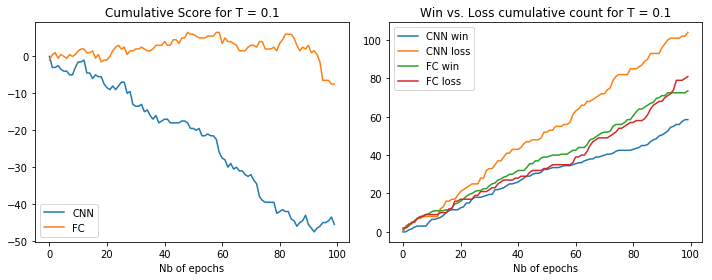

Average score per epoch for CNN is : -0.455
Average score per epoch for FC is : -0.075
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 5, 5, 2)           0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 2, 2, 16)          304       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 1, 1, 32)          2080      
_________________________________________________________________
flatten_23 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_66 (Dense)             (None, 4)                 132       
Total params: 3,572
Trainable params: 3,572
Non-trainab

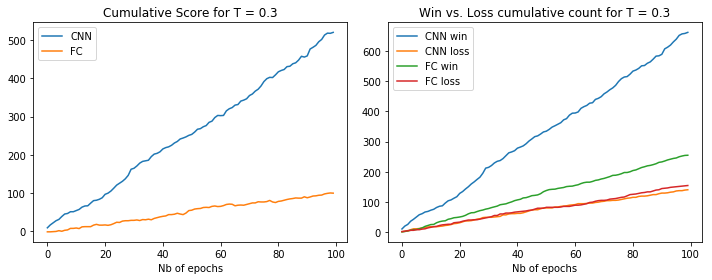

Average score per epoch for CNN is : 5.2
Average score per epoch for FC is : 1.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 5, 5, 2)           0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 2, 2, 16)          304       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 1, 1, 32)          2080      
_________________________________________________________________
flatten_25 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_72 (Dense)             (None, 4)                 132       
Total params: 3,572
Trainable params: 3,572
Non-trainable par

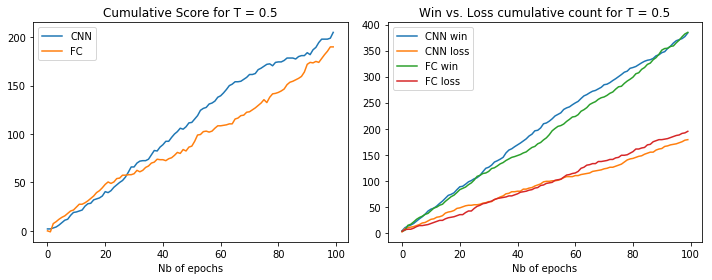

Average score per epoch for CNN is : 2.05
Average score per epoch for FC is : 1.9
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 5, 5, 2)           0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 2, 2, 16)          304       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 1, 1, 32)          2080      
_________________________________________________________________
flatten_27 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_78 (Dense)             (None, 4)                 132       
Total params: 3,572
Trainable params: 3,572
Non-trainable pa

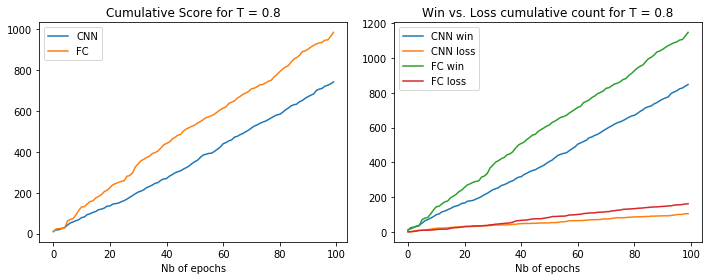

Average score per epoch for CNN is : 7.42
Average score per epoch for FC is : 9.845


In [28]:
# testing
name = ['CNN', 'FC']
epochs_test = 100
for temp in [0.1, 0.3, 0.5, 0.8]:
    env = Environment(grid_size=size, max_time=T, temperature=temp)
    agent_cnn = DQN_CNN(size, lr=0.01, epsilon = 0.1, memory_size=2000, batch_size=32, dense=True)
    agent_cnn.load(name_weights='cnn_train_{}_model.h5'.format(temp),name_model='cnn_train_{}_model.json'.format(temp))
    list_wl_cn, list_score_cn = test(agent_cnn, env,epochs_test, prefix='cnn_test', eps=True)
    agent_fc = DQN_FC(size, lr=0.01, epsilon=0.1, memory_size=2000, batch_size=32, nb_layer=3, nb_neur=32)
    agent_fc.load(name_weights='fc_train_{}_model.h5'.format(temp), name_model='fc_train_{}_model.json'.format(temp))
    list_wl_fc, list_score_fc = test(agent_fc, env, epochs_test, prefix='fc_test', eps=True)
    print('# Testing for T={}'.format(temp))
    plot_comp(list_score_cn, list_score_fc, list_wl_cn, list_wl_fc, temp, name)

* ### For T=0.1
  #### CNN:
  ![SegmentLocal](cnn_test_01_test.gif "segment")

  #### FC :
  ![SegmentLocal](fc_test_01_test.gif "segment")

* ### For T=0.3
  #### CNN:
  ![SegmentLocal](cnn_test_03_test.gif "segment")
  
  #### FC:
  ![SegmentLocal](fc_test_03_test.gif "segment")

* ### For T=0.5
  #### CNN:
  ![SegmentLocal](cnn_test_05_test.gif "segment")
  
  #### FC:
  ![SegmentLocal](fc_test_05_test.gif "segment")
  
* ### For T=0.8
  #### CNN:
  ![SegmentLocal](cnn_test_08_test.gif "segment")
  
  #### FC:
  ![SegmentLocal](fc_test_08_test.gif "segment")

***

When looking at the test results (both graphs and video) of the bot, several comments can be made:
  * regardless of the type of DQN (i.e. FC or CNN) used and the environment setup, the bot tends not to explore the map and stay blocked, oscillating between two cells and not moving elsewhere. I tried to tune the hyperparameters (depth, width) of the network and the epsilon value used during training but it did not improved the average score when testing.
  * when temperature is set to a very low value (typically 0.1), which means that rewards and punishments are sparse, both bots failed to win the game, ending the testing phase with an average score of -0.46 (CNN) and -0.08 (FC). It is a common and well documented failure of the vanilla DQN algorithm, which failed when confronted to sparse reward signal since null often null reward does not give any insight if the action taken was worth it or not.
  * with temperature in the medium range (0.3 and 0.5), the DQN CNN agent performs better than the DQN FC agent. For T=0.3, the average score is 5.2 (CNN) vs. 1 (FC) and for T=0.5, one gets 2.05 (CNN) vs. 1.9 (FC). One explanation could be that the CNN leverages information in the graph better when information is quite sparse. Indeed, when temperature increases, performance of the DQN FC gets closer to the performance of the DQN CNN.

***

***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.



In [30]:
def eps_decrease(e, epoch):
    """
    function to decrease eps according to the followin scheme : linear decrease from 0 to 0.1 during the first 
    half of the epochs, then fixed to 0.1
    """
    if e < 0.5*epoch:
        return -1.8/epoch*e + 1
    else:
        return 0.1

In [31]:
def train_explore(agent, env, epoch, prefix='', change_eps=False):
    # Number of won games
    score = 0
    loss = 0
  
    list_wl = np.zeros((epoch, 2))
    list_score = np.zeros(epoch)
    list_loss = []
    
    func_eps = lambda eps : eps_decrease(eps, epoch)
    
    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        # Change eps if needed
        if change_eps:
            agent.set_epsilon(func_eps(e))
        
        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action, train=True)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose - reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)
            list_loss.append(loss)
            
        # Save as a mp4
        if e % 10 == 0:
            env.draw('{}_{}_{}'.format(prefix,env.temperature,e))

        # Update stats
        score += win-lose
        list_score[e] = score
        list_wl[e, 0] = win
        list_wl[e, 1] = lose

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {:.4f}/{:.4f} ({:.4f}) | Eps {:.3f}"
              .format(e, epoch, loss, win, lose, win-lose, func_eps(e)))
        agent.save(name_weights='{}_{}_model.h5'.format(prefix, env.temperature), name_model='{}_{}_model.json'.format(prefix, env.temperature))
    
    return list_wl, list_score, list_loss 
  
  
   
class EnvironmentExploring(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size + 4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size, grid_size))
        self.position = np.zeros((grid_size, grid_size))
        self.malus_position = np.zeros((grid_size, grid_size))

        # coordinate of the cat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale = 16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))

    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size, self.grid_size, 3), dtype=np.uint8) + 128
        b[self.board>0,0] = 256
        b[self.board < 0, 2] = 256
        b[self.x,self.y,:]=256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:] = b


    def act(self, action, train=False):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size - 3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x + 1
            else:
                self.x = self.x - 1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        
        # define malus (-0.1) is the state has already been visited
        if train:
            reward = reward - self.malus_position[self.x, self.y]
        self.malus_position[self.x, self.y] = 0.1
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        # 3 "feature" states instead of 2
        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                            self.board.reshape(self.grid_size, self.grid_size,1),
                            self.position.reshape(self.grid_size, self.grid_size,1)),axis=2
                            )
        state = state[self.x-2:self.x+3, self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]

        bonus = 0.5*np.random.binomial(1, self.temperature, size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size, self.grid_size)

        malus = -1.0*np.random.binomial(1, self.temperature, size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))

        malus[bonus>0] = 0

        self.board = bonus + malus
        
        self.malus_position = np.zeros((self.grid_size, self.grid_size))

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                            self.board.reshape(self.grid_size, self.grid_size,1),
                            self.position.reshape(self.grid_size, self.grid_size,1)),axis=2
                            )
        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state
    

In [49]:
# Training
epochs_train = 500
env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=0.01, epsilon=0.1, memory_size=2000, batch_size=32, n_state=3, dense=True)
list_wl_exp, list_score_exp, list_loss_exp = train_explore(agent, env, epochs_train, prefix='cnn_train_explore', change_eps=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 5, 5, 3)           0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 2, 2, 16)          448       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 1, 1, 32)          2080      
_________________________________________________________________
flatten_11 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 132       
Total params: 3,716
Trainable params: 3,716
Non-trainable params: 0
_________________________________________________________________
Epoch 00

Epoch 085/500 | Loss 0.1478 | Win/lose count 12.0000/30.5000 (-18.5000) | Eps 0.694
Epoch 086/500 | Loss 0.1709 | Win/lose count 19.0000/24.2000 (-5.2000) | Eps 0.690
Epoch 087/500 | Loss 0.1747 | Win/lose count 20.5000/19.3000 (1.2000) | Eps 0.687
Epoch 088/500 | Loss 0.1671 | Win/lose count 18.0000/25.9000 (-7.9000) | Eps 0.683
Epoch 089/500 | Loss 0.1406 | Win/lose count 15.5000/23.4000 (-7.9000) | Eps 0.680
Epoch 090/500 | Loss 0.1596 | Win/lose count 18.0000/26.3000 (-8.3000) | Eps 0.676
Epoch 091/500 | Loss 0.1620 | Win/lose count 21.0000/27.4000 (-6.4000) | Eps 0.672
Epoch 092/500 | Loss 0.1832 | Win/lose count 16.0000/22.0000 (-6.0000) | Eps 0.669
Epoch 093/500 | Loss 0.1757 | Win/lose count 17.0000/28.4000 (-11.4000) | Eps 0.665
Epoch 094/500 | Loss 0.1858 | Win/lose count 15.0000/34.3000 (-19.3000) | Eps 0.662
Epoch 095/500 | Loss 0.1617 | Win/lose count 20.5000/19.3000 (1.2000) | Eps 0.658
Epoch 096/500 | Loss 0.1469 | Win/lose count 10.5000/18.5000 (-8.0000) | Eps 0.654
Epo

Epoch 184/500 | Loss 0.1149 | Win/lose count 15.5000/18.2000 (-2.7000) | Eps 0.338
Epoch 185/500 | Loss 0.1329 | Win/lose count 25.5000/21.2000 (4.3000) | Eps 0.334
Epoch 186/500 | Loss 0.1513 | Win/lose count 22.0000/18.9000 (3.1000) | Eps 0.330
Epoch 187/500 | Loss 0.1110 | Win/lose count 21.5000/13.1000 (8.4000) | Eps 0.327
Epoch 188/500 | Loss 0.1336 | Win/lose count 23.0000/17.3000 (5.7000) | Eps 0.323
Epoch 189/500 | Loss 0.1252 | Win/lose count 22.0000/14.2000 (7.8000) | Eps 0.320
Epoch 190/500 | Loss 0.1139 | Win/lose count 15.0000/20.5000 (-5.5000) | Eps 0.316
Epoch 191/500 | Loss 0.0972 | Win/lose count 12.5000/21.9000 (-9.4000) | Eps 0.312
Epoch 192/500 | Loss 0.1307 | Win/lose count 23.5000/12.9000 (10.6000) | Eps 0.309
Epoch 193/500 | Loss 0.1305 | Win/lose count 20.0000/17.3000 (2.7000) | Eps 0.305
Epoch 194/500 | Loss 0.0881 | Win/lose count 21.0000/21.4000 (-0.4000) | Eps 0.302
Epoch 195/500 | Loss 0.1332 | Win/lose count 18.0000/15.0000 (3.0000) | Eps 0.298
Epoch 196/5

Epoch 284/500 | Loss 0.1090 | Win/lose count 21.0000/17.8000 (3.2000) | Eps 0.100
Epoch 285/500 | Loss 0.0939 | Win/lose count 19.0000/17.3000 (1.7000) | Eps 0.100
Epoch 286/500 | Loss 0.0945 | Win/lose count 14.5000/18.0000 (-3.5000) | Eps 0.100
Epoch 287/500 | Loss 0.0623 | Win/lose count 16.0000/17.1000 (-1.1000) | Eps 0.100
Epoch 288/500 | Loss 0.0947 | Win/lose count 14.5000/14.8000 (-0.3000) | Eps 0.100
Epoch 289/500 | Loss 0.1014 | Win/lose count 15.0000/20.7000 (-5.7000) | Eps 0.100
Epoch 290/500 | Loss 0.0993 | Win/lose count 15.5000/14.9000 (0.6000) | Eps 0.100
Epoch 291/500 | Loss 0.0738 | Win/lose count 23.0000/13.3000 (9.7000) | Eps 0.100
Epoch 292/500 | Loss 0.0725 | Win/lose count 20.5000/14.9000 (5.6000) | Eps 0.100
Epoch 293/500 | Loss 0.1048 | Win/lose count 16.0000/15.8000 (0.2000) | Eps 0.100
Epoch 294/500 | Loss 0.0610 | Win/lose count 19.5000/19.5000 (0.0000) | Eps 0.100
Epoch 295/500 | Loss 0.0721 | Win/lose count 4.0000/19.8000 (-15.8000) | Eps 0.100
Epoch 296/5

Epoch 384/500 | Loss 0.1061 | Win/lose count 13.5000/16.7000 (-3.2000) | Eps 0.100
Epoch 385/500 | Loss 0.0818 | Win/lose count 20.5000/11.4000 (9.1000) | Eps 0.100
Epoch 386/500 | Loss 0.0835 | Win/lose count 19.5000/19.2000 (0.3000) | Eps 0.100
Epoch 387/500 | Loss 0.0815 | Win/lose count 21.5000/19.7000 (1.8000) | Eps 0.100
Epoch 388/500 | Loss 0.0484 | Win/lose count 23.0000/13.1000 (9.9000) | Eps 0.100
Epoch 389/500 | Loss 0.0840 | Win/lose count 18.5000/19.7000 (-1.2000) | Eps 0.100
Epoch 390/500 | Loss 0.0542 | Win/lose count 13.5000/17.0000 (-3.5000) | Eps 0.100
Epoch 391/500 | Loss 0.0762 | Win/lose count 13.0000/18.3000 (-5.3000) | Eps 0.100
Epoch 392/500 | Loss 0.0770 | Win/lose count 7.0000/18.9000 (-11.9000) | Eps 0.100
Epoch 393/500 | Loss 0.0735 | Win/lose count 15.5000/16.0000 (-0.5000) | Eps 0.100
Epoch 394/500 | Loss 0.0465 | Win/lose count 23.5000/16.9000 (6.6000) | Eps 0.100
Epoch 395/500 | Loss 0.0811 | Win/lose count 20.0000/13.3000 (6.7000) | Eps 0.100
Epoch 396/

Epoch 484/500 | Loss 0.0502 | Win/lose count 21.0000/16.9000 (4.1000) | Eps 0.100
Epoch 485/500 | Loss 0.0533 | Win/lose count 21.0000/15.9000 (5.1000) | Eps 0.100
Epoch 486/500 | Loss 0.0477 | Win/lose count 22.0000/18.7000 (3.3000) | Eps 0.100
Epoch 487/500 | Loss 0.0515 | Win/lose count 16.5000/17.7000 (-1.2000) | Eps 0.100
Epoch 488/500 | Loss 0.0659 | Win/lose count 16.5000/18.5000 (-2.0000) | Eps 0.100
Epoch 489/500 | Loss 0.0843 | Win/lose count 13.5000/14.1000 (-0.6000) | Eps 0.100
Epoch 490/500 | Loss 0.0768 | Win/lose count 25.0000/18.0000 (7.0000) | Eps 0.100
Epoch 491/500 | Loss 0.0862 | Win/lose count 23.5000/14.4000 (9.1000) | Eps 0.100
Epoch 492/500 | Loss 0.0554 | Win/lose count 19.0000/16.7000 (2.3000) | Eps 0.100
Epoch 493/500 | Loss 0.0628 | Win/lose count 15.0000/20.7000 (-5.7000) | Eps 0.100
Epoch 494/500 | Loss 0.0840 | Win/lose count 16.0000/19.9000 (-3.9000) | Eps 0.100
Epoch 495/500 | Loss 0.0612 | Win/lose count 11.5000/18.8000 (-7.3000) | Eps 0.100
Epoch 496/

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 5, 5, 2)           0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 2, 2, 16)          304       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 1, 1, 32)          2080      
_________________________________________________________________
flatten_31 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_87 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_88 (Dense)             (None, 4)                 132       
Total params: 3,572
Trainable params: 3,572
Non-trainable params: 0
_________________________________________________________________
________

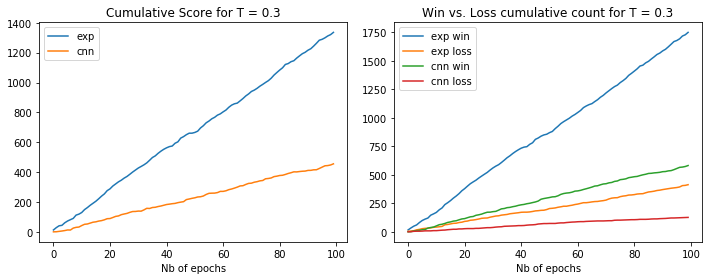

Average score per epoch for exp is : 13.36
Average score per epoch for cnn is : 4.55


In [33]:
# Evaluation
epochs_test = 100
env1 = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)
env2 = Environment(grid_size=size, max_time=T, temperature=0.3)
agent_exp = DQN_CNN(size, lr=0.01, epsilon=0.1, memory_size=2000, batch_size=32, dense=True)
agent_exp.load(name_weights='results_good/cnn_train_explore_0.3_model.h5', name_model='results_good/cnn_train_explore_0.3_model.json')
agent_cnn = DQN_CNN(size, lr=0.01, epsilon=0.1, memory_size=2000, batch_size=32, dense=True)
agent_cnn.load(name_weights='results_good/cnn_train_0.3_model.h5', name_model='results_good/cnn_train_0.3_model.json')
list_wl_exp, list_score_exp = test(agent_exp, env1, epochs_test, prefix='cnn_expert_test_explore', eps=True)
list_wl_cnn, list_score_cnn = test(agent_cnn, env2, epochs_test, prefix='cnn_test_explore', eps=True)

plot_comp(list_score_exp, list_score_cnn, list_wl_exp, list_wl_cnn, 0.3, ['exp', 'cnn'])

* #### Expert CNN:
![SegmentLocal](expert_test_03_test.gif "segment")

* #### Vanilla CNN:
![SegmentLocal](cnn_test_03_test.gif "segment")

***

With the two proposed tricks, exploration is indeed improved and the agent is not blocked oscillating between two cells (see video enclosed in the git). The test was carried out with temperature set at T=0.3. The average score of the improved CNN during test is 13.4 whereas the average score of the vanilla CNN is only 4.55. Moreover, the test phase was slightly changed compared to the previous test since we used an epsilon greedy test policy with epsilon set very small (0.05) instead of the greedy policy. The idea was to help the vanilla CNN to escape oscillating behavior by allowing it to move randomly to another cell from which it could try to explore the map.


***
***
__BONUS question__ Use the expert DQN from the previous question to generate some winning games. Train a model that mimicks its behavior. Compare the performances.

The idea is to use what is called "imitation learning" in order to train a bot on sample of winning games performed by the expert DQN. In contrast with what we made earlier, the goal is not to train a network to learn a Q-function based on the Bellman equation but instead to directly learn a policy, i.e a mapping $\pi$ from the state space $S$ to the action space $A=[0,1,2,3]$ based on samples of the winning policy collected by an expert. We decided to follow the 'behavioral cloning' method, which casts the imitation learning problem as a supervised learning problem where the goal is to train a classifier, in what follows a neural network. 

The method __collect_imit__ is used to collect winning episodes performed by the expert DQN Agent, which are stored in a __Memory__ object. The __merge_memory__ method merges the collected episodes and create the training batch. The __DQN_imit__ agent uses a neural network derived from the expert DQN, with several convolutional and dense layers. It is trained with Adam optimizer on several mini-batches. 


In [78]:
def collect_imit(agent, env, win_epochs, n_states=3):
    # Number of won games
    score = 0
    w_epoch = 0
    list_memory = []
    
    while w_epoch < win_epochs:
      
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will end
        game_over = False
        t = 0
        win = 0
        lose = 0
        memory = Memory(env.max_time, nb_s=n_states)
        
        while not game_over:
                    
            # The agent performs an action
            action = agent.act(state, train=False, eps=True)
            
            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action, train=False)
            memory.remember([prev_state, state, action, reward, game_over])
            
            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Save frame
            env.get_frame(t)
            t = t + 1

        # Update stats
        score = win - lose
        
        # store game if it is a winning game
        if score >= 0:
            list_memory.append(memory)
            w_epoch += 1
        
        # print 
        print("Win/lose count {}/{}. Score ({})"
              .format(win, lose, score))
    
    return list_memory

In [72]:
def merge_memory(list_memory, delete_malus=False):
  # merge list of memory into one batch
    l_state = []
    l_action = []
    for mem in list_memory:
        s = mem.state
        act = mem.action
        if mem.full:
            pass
        else:
            s = s[:mem.cursor-1]
            act = act[:mem.cursor-1]
        # if imitation agent trained without the malus map
        if delete_malus:
            s = s[:,:,:,1:]
        l_state.append(s)
        l_action.append(act)
    
    n_input = np.concatenate(l_state, axis=0)
    n_output = np.concatenate(l_action, axis=0)
  
    print('the batch size is {}'.format(n_input.shape[0]))
  
    return n_input, n_output

In [73]:
class DQN_IMIT(DQN):
    def __init__(self, *args,lr=0.1,**kwargs):
        super(DQN_IMIT, self).__init__(*args,**kwargs)
        
        # NN training model
        screen_input = Input(shape=(5,5,self.n_state))
        s1 = Conv2D(32, (3,3), strides=(2, 2), 
                    activation='relu')(screen_input)
        s1 = Conv2D(32, (2,2), strides=(2, 2), 
                    activation='relu')(s1)
        s1 = Flatten()(s1)
        s1 = Dense(32, activation='relu')(s1)
        pred = Dense(4,activation='softmax')(s1)
        model = Model(inputs=screen_input, outputs=pred)
        
        model.summary()
        model.compile(Adam(lr=lr, decay=1e-4), loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
        self.model = model
  
  

In [74]:
# plot function
def plot_hist(hist):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
    
    ax1.plot(hist.history['loss'], marker='', label="Train")
    ax1.plot(hist.history['val_loss'], marker='', label="Test")
    ax1.set_xlabel(r'Epoch')
    ax1.set_ylabel(r'Loss')
    ax1.set_title(r'Model Loss')
    ax1.legend()
    
    ax2.plot(hist.history['acc'], marker='', label="Train")
    ax2.plot(hist.history['val_acc'], marker='', label="Test")
    ax2.set_xlabel(r'Epoch')
    ax2.set_ylabel(r'Accuracy')
    ax2.set_title(r'Model accuracy')
    ax2.legend()
    fig.tight_layout()
    plt.show()

In [79]:
# collect wining games from the expert DQN
# use memory object to store the winning games
win_epochs = 2000
env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)
agent_expert = DQN_CNN(size, lr=0.01, epsilon=0.1, memory_size=2000, batch_size=32, n_state=3)
agent_expert.load(name_weights='cnn_train_explore_0.3_model.h5', name_model='cnn_train_explore_0.3_model.json')
list_memory = collect_imit(agent_expert, env, win_epochs)
n_input, n_output = merge_memory(list_memory)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 5, 5, 3)           0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 2, 2, 16)          448       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 1, 1, 32)          2080      
_________________________________________________________________
flatten_36 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_94 (Dense)             (None, 4)                 132       
Total params: 2,660
Trainable params: 2,660
Non-trainable params: 0
_________________________________________________________________
Win/lose count 19.0/5.0. Score (14.0)
Win/lose count 16.5/8.0. Score (8.5)
Win/lose count 13.0/1.0. Score (12.0)
Win/lose count 19.0/2.0. Sc

Win/lose count 13.0/3.0. Score (10.0)
Win/lose count 13.5/1.0. Score (12.5)
Win/lose count 22.0/2.0. Score (20.0)
Win/lose count 21.0/8.0. Score (13.0)
Win/lose count 17.5/1.0. Score (16.5)
Win/lose count 19.5/3.0. Score (16.5)
Win/lose count 17.0/2.0. Score (15.0)
Win/lose count 22.5/6.0. Score (16.5)
Win/lose count 3.0/1.0. Score (2.0)
Win/lose count 10.5/6.0. Score (4.5)
Win/lose count 24.0/3.0. Score (21.0)
Win/lose count 13.5/5.0. Score (8.5)
Win/lose count 19.5/7.0. Score (12.5)
Win/lose count 24.5/4.0. Score (20.5)
Win/lose count 27.0/5.0. Score (22.0)
Win/lose count 3.5/1.0. Score (2.5)
Win/lose count 15.5/6.0. Score (9.5)
Win/lose count 21.5/4.0. Score (17.5)
Win/lose count 16.5/4.0. Score (12.5)
Win/lose count 15.5/6.0. Score (9.5)
Win/lose count 13.5/3.0. Score (10.5)
Win/lose count 21.5/1.0. Score (20.5)
Win/lose count 15.5/5.0. Score (10.5)
Win/lose count 19.0/2.0. Score (17.0)
Win/lose count 15.0/8.0. Score (7.0)
Win/lose count 19.5/3.0. Score (16.5)
Win/lose count 15.5/2

Win/lose count 16.5/6.0. Score (10.5)
Win/lose count 20.0/3.0. Score (17.0)
Win/lose count 15.0/2.0. Score (13.0)
Win/lose count 19.0/6.0. Score (13.0)
Win/lose count 18.0/5.0. Score (13.0)
Win/lose count 14.0/1.0. Score (13.0)
Win/lose count 27.0/1.0. Score (26.0)
Win/lose count 15.5/3.0. Score (12.5)
Win/lose count 16.5/4.0. Score (12.5)
Win/lose count 9.0/2.0. Score (7.0)
Win/lose count 15.5/4.0. Score (11.5)
Win/lose count 20.0/5.0. Score (15.0)
Win/lose count 26.0/4.0. Score (22.0)
Win/lose count 14.5/2.0. Score (12.5)
Win/lose count 22.5/6.0. Score (16.5)
Win/lose count 25.0/6.0. Score (19.0)
Win/lose count 22.0/2.0. Score (20.0)
Win/lose count 13.5/7.0. Score (6.5)
Win/lose count 20.0/16.0. Score (4.0)
Win/lose count 16.0/3.0. Score (13.0)
Win/lose count 16.0/3.0. Score (13.0)
Win/lose count 20.0/8.0. Score (12.0)
Win/lose count 22.5/5.0. Score (17.5)
Win/lose count 18.5/8.0. Score (10.5)
Win/lose count 20.0/12.0. Score (8.0)
Win/lose count 16.5/7.0. Score (9.5)
Win/lose count 9

Win/lose count 18.0/4.0. Score (14.0)
Win/lose count 17.5/5.0. Score (12.5)
Win/lose count 21.0/4.0. Score (17.0)
Win/lose count 19.5/7.0. Score (12.5)
Win/lose count 23.5/2.0. Score (21.5)
Win/lose count 18.5/3.0. Score (15.5)
Win/lose count 14.0/6.0. Score (8.0)
Win/lose count 22.0/4.0. Score (18.0)
Win/lose count 15.5/2.0. Score (13.5)
Win/lose count 19.5/2.0. Score (17.5)
Win/lose count 24.5/5.0. Score (19.5)
Win/lose count 12.0/1.0. Score (11.0)
Win/lose count 16.5/2.0. Score (14.5)
Win/lose count 17.0/7.0. Score (10.0)
Win/lose count 19.0/3.0. Score (16.0)
Win/lose count 15.5/9.0. Score (6.5)
Win/lose count 17.5/4.0. Score (13.5)
Win/lose count 21.0/5.0. Score (16.0)
Win/lose count 17.5/5.0. Score (12.5)
Win/lose count 8.5/3.0. Score (5.5)
Win/lose count 14.0/1.0. Score (13.0)
Win/lose count 24.0/6.0. Score (18.0)
Win/lose count 28.5/6.0. Score (22.5)
Win/lose count 25.5/5.0. Score (20.5)
Win/lose count 21.0/7.0. Score (14.0)
Win/lose count 24.5/3.0. Score (21.5)
Win/lose count 1

Win/lose count 8.5/0. Score (8.5)
Win/lose count 21.5/7.0. Score (14.5)
Win/lose count 21.0/6.0. Score (15.0)
Win/lose count 19.5/6.0. Score (13.5)
Win/lose count 12.0/3.0. Score (9.0)
Win/lose count 10.0/4.0. Score (6.0)
Win/lose count 11.0/1.0. Score (10.0)
Win/lose count 6.0/1.0. Score (5.0)
Win/lose count 24.0/2.0. Score (22.0)
Win/lose count 11.5/4.0. Score (7.5)
Win/lose count 16.5/8.0. Score (8.5)
Win/lose count 19.5/1.0. Score (18.5)
Win/lose count 14.0/7.0. Score (7.0)
Win/lose count 10.0/1.0. Score (9.0)
Win/lose count 16.0/2.0. Score (14.0)
Win/lose count 13.0/1.0. Score (12.0)
Win/lose count 19.5/4.0. Score (15.5)
Win/lose count 17.0/3.0. Score (14.0)
Win/lose count 4.5/0. Score (4.5)
Win/lose count 27.0/1.0. Score (26.0)
Win/lose count 20.0/6.0. Score (14.0)
Win/lose count 14.5/3.0. Score (11.5)
Win/lose count 14.0/4.0. Score (10.0)
Win/lose count 11.0/2.0. Score (9.0)
Win/lose count 15.0/6.0. Score (9.0)
Win/lose count 14.5/7.0. Score (7.5)
Win/lose count 18.0/3.0. Score 

Win/lose count 17.5/2.0. Score (15.5)
Win/lose count 18.5/5.0. Score (13.5)
Win/lose count 26.5/8.0. Score (18.5)
Win/lose count 21.0/2.0. Score (19.0)
Win/lose count 22.5/6.0. Score (16.5)
Win/lose count 21.0/5.0. Score (16.0)
Win/lose count 17.5/4.0. Score (13.5)
Win/lose count 20.5/6.0. Score (14.5)
Win/lose count 15.0/4.0. Score (11.0)
Win/lose count 20.0/3.0. Score (17.0)
Win/lose count 14.0/3.0. Score (11.0)
Win/lose count 18.5/2.0. Score (16.5)
Win/lose count 19.0/8.0. Score (11.0)
Win/lose count 20.5/8.0. Score (12.5)
Win/lose count 11.0/4.0. Score (7.0)
Win/lose count 18.0/9.0. Score (9.0)
Win/lose count 25.5/5.0. Score (20.5)
Win/lose count 24.5/6.0. Score (18.5)
Win/lose count 17.0/2.0. Score (15.0)
Win/lose count 7.0/4.0. Score (3.0)
Win/lose count 23.0/4.0. Score (19.0)
Win/lose count 16.0/8.0. Score (8.0)
Win/lose count 17.5/7.0. Score (10.5)
Win/lose count 17.0/8.0. Score (9.0)
Win/lose count 18.5/5.0. Score (13.5)
Win/lose count 18.5/4.0. Score (14.5)
Win/lose count 21.

Win/lose count 9.0/6.0. Score (3.0)
Win/lose count 7.5/1.0. Score (6.5)
Win/lose count 24.0/6.0. Score (18.0)
Win/lose count 12.0/4.0. Score (8.0)
Win/lose count 16.5/3.0. Score (13.5)
Win/lose count 10.0/7.0. Score (3.0)
Win/lose count 20.5/6.0. Score (14.5)
Win/lose count 23.0/7.0. Score (16.0)
Win/lose count 13.0/3.0. Score (10.0)
Win/lose count 15.5/2.0. Score (13.5)
Win/lose count 16.0/5.0. Score (11.0)
Win/lose count 20.5/5.0. Score (15.5)
Win/lose count 16.5/1.0. Score (15.5)
Win/lose count 16.0/2.0. Score (14.0)
Win/lose count 14.5/4.0. Score (10.5)
Win/lose count 16.0/6.0. Score (10.0)
Win/lose count 19.0/2.0. Score (17.0)
Win/lose count 19.0/4.0. Score (15.0)
Win/lose count 25.5/4.0. Score (21.5)
Win/lose count 26.0/4.0. Score (22.0)
Win/lose count 18.5/6.0. Score (12.5)
Win/lose count 15.0/3.0. Score (12.0)
Win/lose count 21.0/5.0. Score (16.0)
Win/lose count 14.5/4.0. Score (10.5)
Win/lose count 23.0/6.0. Score (17.0)
Win/lose count 15.5/8.0. Score (7.5)
Win/lose count 13.0

Win/lose count 12.0/2.0. Score (10.0)
Win/lose count 16.5/4.0. Score (12.5)
Win/lose count 22.0/3.0. Score (19.0)
Win/lose count 18.5/6.0. Score (12.5)
Win/lose count 14.5/9.0. Score (5.5)
Win/lose count 21.0/5.0. Score (16.0)
Win/lose count 14.5/4.0. Score (10.5)
Win/lose count 7.5/0. Score (7.5)
Win/lose count 17.0/4.0. Score (13.0)
Win/lose count 9.5/2.0. Score (7.5)
Win/lose count 21.5/3.0. Score (18.5)
Win/lose count 18.5/4.0. Score (14.5)
Win/lose count 19.0/4.0. Score (15.0)
Win/lose count 24.5/2.0. Score (22.5)
Win/lose count 18.5/2.0. Score (16.5)
Win/lose count 20.0/6.0. Score (14.0)
Win/lose count 7.5/7.0. Score (0.5)
Win/lose count 18.5/5.0. Score (13.5)
Win/lose count 21.0/5.0. Score (16.0)
Win/lose count 14.5/7.0. Score (7.5)
Win/lose count 14.0/5.0. Score (9.0)
Win/lose count 23.5/8.0. Score (15.5)
Win/lose count 18.5/6.0. Score (12.5)
Win/lose count 15.0/0. Score (15.0)
Win/lose count 23.0/8.0. Score (15.0)
Win/lose count 19.0/1.0. Score (18.0)
Win/lose count 16.5/2.0. 

Win/lose count 18.5/6.0. Score (12.5)
Win/lose count 23.5/5.0. Score (18.5)
Win/lose count 18.0/1.0. Score (17.0)
Win/lose count 18.5/4.0. Score (14.5)
Win/lose count 20.5/2.0. Score (18.5)
Win/lose count 13.5/1.0. Score (12.5)
Win/lose count 9.5/2.0. Score (7.5)
Win/lose count 19.0/3.0. Score (16.0)
Win/lose count 16.5/4.0. Score (12.5)
Win/lose count 16.0/5.0. Score (11.0)
Win/lose count 8.0/1.0. Score (7.0)
Win/lose count 19.5/3.0. Score (16.5)
Win/lose count 22.0/2.0. Score (20.0)
Win/lose count 12.0/4.0. Score (8.0)
Win/lose count 22.5/1.0. Score (21.5)
Win/lose count 23.5/5.0. Score (18.5)
Win/lose count 15.0/2.0. Score (13.0)
Win/lose count 14.5/4.0. Score (10.5)
Win/lose count 17.0/6.0. Score (11.0)
Win/lose count 16.5/4.0. Score (12.5)
Win/lose count 13.0/2.0. Score (11.0)
Win/lose count 23.5/8.0. Score (15.5)
Win/lose count 22.0/6.0. Score (16.0)
Win/lose count 17.0/3.0. Score (14.0)
Win/lose count 20.5/6.0. Score (14.5)
Win/lose count 13.0/4.0. Score (9.0)
Win/lose count 16.

Win/lose count 18.0/2.0. Score (16.0)
Win/lose count 4.0/1.0. Score (3.0)
Win/lose count 20.0/3.0. Score (17.0)
Win/lose count 13.5/1.0. Score (12.5)
Win/lose count 19.0/7.0. Score (12.0)
Win/lose count 20.0/1.0. Score (19.0)
Win/lose count 11.0/4.0. Score (7.0)
Win/lose count 21.0/3.0. Score (18.0)
Win/lose count 14.5/4.0. Score (10.5)
Win/lose count 20.0/3.0. Score (17.0)
Win/lose count 18.0/3.0. Score (15.0)
Win/lose count 21.0/6.0. Score (15.0)
Win/lose count 20.5/9.0. Score (11.5)
Win/lose count 18.5/5.0. Score (13.5)
Win/lose count 16.5/4.0. Score (12.5)
Win/lose count 10.5/5.0. Score (5.5)
Win/lose count 13.0/5.0. Score (8.0)
Win/lose count 23.0/3.0. Score (20.0)
Win/lose count 9.0/2.0. Score (7.0)
Win/lose count 19.0/7.0. Score (12.0)
Win/lose count 20.5/6.0. Score (14.5)
Win/lose count 13.5/3.0. Score (10.5)
Win/lose count 23.5/3.0. Score (20.5)
Win/lose count 23.0/3.0. Score (20.0)
Win/lose count 23.5/4.0. Score (19.5)
Win/lose count 14.0/2.0. Score (12.0)
Win/lose count 20.5

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        (None, 5, 5, 3)           0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 2, 2, 32)          896       
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 1, 1, 32)          4128      
_________________________________________________________________
flatten_38 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_97 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_98 (Dense)             (None, 4)                 132       
Total params: 6,212
Trainable params: 6,212
Non-trainable params: 0
_________________________________________________________________
Train on

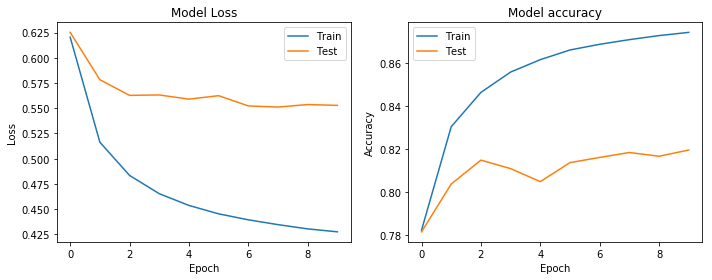

In [84]:
# define a new learning bot
agent_imit = DQN_IMIT(size, lr=0.01, epsilon=0.1, memory_size=2000, batch_size=32, n_state=3)

# imitation learning (ie supervised learning on the winning games extracted from the expert DQN)
hist = agent_imit.model.fit(n_input, n_output, epochs=10, batch_size=32, validation_split=0.05)
plot_hist(hist)


Testing expert_test for temperature 0.3
Final score: 13.0
Testing imit_test for temperature 0.3
Final score: 12.32


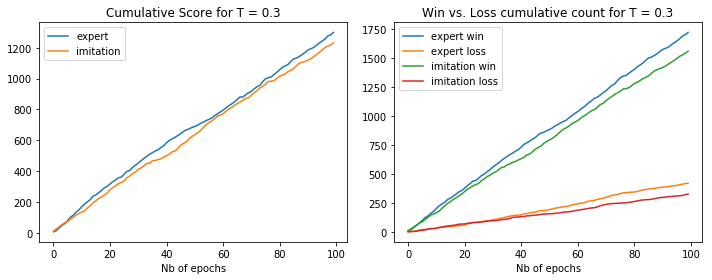

Average score per epoch for expert is : 13.0
Average score per epoch for imitation is : 12.32


In [85]:
# test of the imitation agent
epochs_test = 100
list_wl_exp, list_score_exp = test(agent_expert, env, epochs_test, prefix='expert_test', eps=True)
list_wl_imt, list_score_imt = test(agent_imit, env, epochs_test, prefix='imit_test', eps=True)
plot_comp(list_score_exp, list_score_imt, list_wl_exp, list_wl_imt, 0.3, ['expert', 'imitation'])

* #### Expert CNN:
![SegmentLocal](expert_test_03_test.gif "segment")

* #### Imitation Agent:
![SegmentLocal](imit_test_03_test.gif "segment")

* The imitation agent is performing nearly as good as the the expert CNN, with an average score per epoch of 12.32 vs. 13.0 for the expert CNN. It as learn a nealy optimal policy only from raw samples from winning parties of the expert DQN.

***